In [1]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

from queue import Queue 
import threading
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm

torch.set_default_dtype(torch.float32)

DEVICE = torch.device("cpu")

In [2]:
import gym
env = gym.make('LunarLander-v2')

/home/ototot/anaconda3/envs/ML/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class Actor(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [4]:
class ActorAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state).to(DEVICE))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [5]:
actor = Actor().to(DEVICE)
actor_agent = ActorAgent(actor)

In [6]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 16),
            nn.ReLU(True),
            nn.Linear(16, 8),
            nn.ReLU(True),
            nn.Linear(8, 1)
        )

    def forward(self, state):
        return self.model(state)

In [7]:
class CriticAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-3)

    def learn(self, advantage):
        loss = (advantage ** 2).sum()
        
#         print('%.4f' % loss.detach().item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def evaulate(self, state):
        return self.network(torch.FloatTensor(state).to(DEVICE))[0]

In [8]:
critic = Critic().to(DEVICE)
critic_agent = CriticAgent(critic)

In [9]:
EPISODE_PER_BATCH = 128 # 每蒐集 128 個 episodes 更新一次 agent
NUM_BATCH = 1000         # 總共更新 1000 次
GAMMA     = 0.9         # 衰敗率

In [10]:
# 訓練前先確認network處於train的狀態
actor_agent.network.train()
critic_agent.network.train()

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
prg_bar.set_description(f"Total: ?, Final: ?")

for batch in prg_bar:

    advantages, log_probs = [], []
    total_rewards, final_rewards = [], []
    
    # 蒐集訓練資料
    def f(result_queue):        
        env = gym.make('LunarLander-v2')
        state = env.reset()

        total_reward  = 0
        local_log_probs, local_advantages = [], []
        
        while True:

            action, log_prob = actor_agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            local_log_probs.append(log_prob)
            local_advantages.append(reward + GAMMA * critic_agent.evaulate(next_state) - critic_agent.evaulate(state))
            total_reward += reward
            state = next_state

            if done:
                result_queue.put((local_log_probs, local_advantages, reward, total_reward))
                del env
                break
    
    result_queue = Queue()
    threads = []
    for i in range(EPISODE_PER_BATCH):
        threads.append(threading.Thread(target=f, args=(result_queue,)))
        threads[-1].start()

    for t in threads:
        t.join()
        local_log_probs, local_advantages, reward, total_reward = result_queue.get()
        
        final_rewards.append(reward)
        total_rewards.append(total_reward)
        advantages += local_advantages
        log_probs += local_log_probs
            

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    critic_agent.learn(torch.stack(advantages).to(DEVICE))
    actor_agent.learn(torch.stack(log_probs).to(DEVICE), torch.stack(advantages).detach().to(DEVICE))
    
    del advantages, log_probs, total_rewards, final_rewards, result_queue, threads
    
    gc.collect()

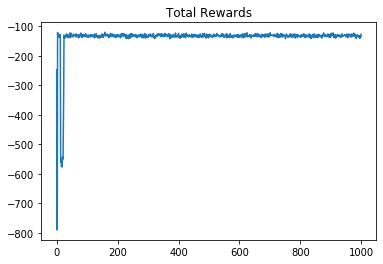

In [11]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

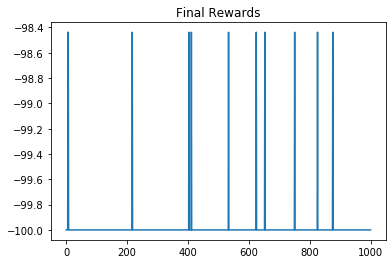

In [12]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

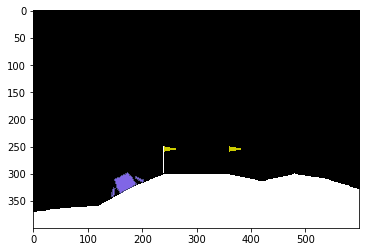

In [13]:
actor_agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = actor_agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [14]:
print(total_reward, reward)

-165.2634328122486 -100
